In [ ]:
!pip install -q bitsandbytes accelerate transformers datasets peft evaluate matplotlib


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import prepare_model_for_kbit_training, get_peft_model, LoraConfig, TaskType
from datasets import load_dataset
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
import torch
import numpy as np
from evaluate import load
import matplotlib.pyplot as plt
from transformers import BitsAndBytesConfig

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# MODEL TRAINING

In [ ]:
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

In [ ]:
model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"]
)

model = get_peft_model(model, peft_config)


# Loading Dataset 

In [ ]:
dataset = load_dataset("Abirate/english_quotes", split="train").shuffle(seed=42).select(range(1000))

def format_prompt(example):
    return {"text": f"### Prompt:\nGive an inspirational quote.\n### Quote:\n{example['quote']}"}

dataset = dataset.map(format_prompt)


In [ ]:
def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

tokenized = dataset.map(tokenize, batched=True)
tokenized.set_format(type="torch", columns=["input_ids", "attention_mask"])


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

# Fine Tuning Model

In [ ]:
training_args = TrainingArguments(
    output_dir="./tinyllama-lora-output",
    per_device_train_batch_size=4,
    num_train_epochs=3,
    logging_steps=5,
    save_steps=50,
    save_total_limit=2,
    learning_rate=2e-4,
    bf16=torch.cuda.is_bf16_supported(),
    report_to="none",
    logging_dir="./logs"
)

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized,
    data_collator=data_collator
)

train_result = trainer.train()


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
C:\Users\FAST\anaconda3\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
5,2.415400
10,1.780800
15,1.551600
20,1.663400
25,1.351000
30,1.312100
35,1.317100
40,1.417900
45,1.373400
50,1.258200


C:\Users\FAST\anaconda3\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\FAST\anaconda3\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\FAST\anaconda3\Lib\site-packages\torch\_d

In [ ]:
final_loss = train_result.training_loss
print(f"Final Training Loss: {final_loss:.4f}")
print(f"Perplexity: {np.exp(final_loss):.2f}")


Final Training Loss: 1.3560
Perplexity: 3.88


# Visualisation

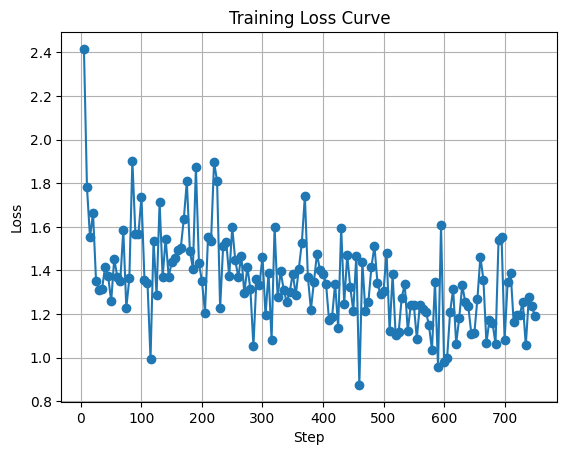

In [ ]:
log_history = trainer.state.log_history
steps = [x["step"] for x in log_history if "loss" in x]
losses = [x["loss"] for x in log_history if "loss" in x]

plt.plot(steps, losses, marker='o')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.show()


In [ ]:
def generate_quote(prompt="Give an inspirational quote."):
    input_ids = tokenizer(f"### Prompt:\n{prompt}\n### Quote:\n", return_tensors="pt").input_ids.cuda()
    output = model.generate(input_ids, max_new_tokens=50, temperature=0.8, do_sample=True)
    print(tokenizer.decode(output[0], skip_special_tokens=True))

generate_quote()


C:\Users\FAST\anaconda3\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\FAST\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


### Prompt:
Give an inspirational quote.
### Quote:
“You must be very brave, though I can only be very foolish.”"I think the difference between people who are brave and those who are foolish is that the brave know when something is foolish and the foolish don't.”


In [ ]:
model.save_pretrained("./tinyllama-lora-quotes")
tokenizer.save_pretrained("./tinyllama-lora-quotes")


('./tinyllama-lora-quotes\\tokenizer_config.json',
 './tinyllama-lora-quotes\\special_tokens_map.json',
 './tinyllama-lora-quotes\\tokenizer.model',
 './tinyllama-lora-quotes\\added_tokens.json',
 './tinyllama-lora-quotes\\tokenizer.json')